In [1]:
import requests
import re
import os
import pandas as pd
from zipfile import ZipFile

def download_rba(urls, out_dir="."):
    # Make sure out_dir exists
    os.makedirs(out_dir, exist_ok=True)

    # Download the files
    for url in urls:
        filename = os.path.basename(url)
        if not filename.endswith(".xls"):
            raise ValueError(f"{filename} is not an xls file")
        filepath = os.path.join(out_dir, filename)
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(filepath, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

        # Load the data
        data = pd.read_excel(filepath)
        yield data

In [2]:
# import data from RBA website
urls = ["https://www.rba.gov.au/statistics/tables/xls-hist/2023-current.xls"]
data_generator = download_rba(urls, out_dir="data")

# Create a list to store the dataframes
df_list = []

# Loop through the generator and append each dataframe to the list
for df in data_generator:
    df_list.append(df)

# Concatenate the dataframes into a single dataframe
all_data = pd.concat(df_list)

In [3]:
# Convert all_data to a pandas dataframe
all_data = pd.DataFrame(all_data)

# Remove columns with NaN values from the header
header_row = all_data.iloc[:12]
header_row = header_row.loc[:, ~header_row.isna().all()]

# Set the header row as column names
all_data.columns = header_row.iloc[0]

# Extract the data rows
data = all_data.iloc[12:].reset_index(drop=True)

# Rename columns to match R script
data = data.rename(columns={
    "Title": "Date"})

In [4]:
data.head(3)

,Date,A$1=USD,Trade-weighted Index May 1970 = 100,A$1=CNY,A$1=JPY,A$1=EUR,A$1=KRW,A$1=GBP,A$1=SGD,A$1=INR,...,A$1=IDR,A$1=VND,A$1=AED,A$1=PGK,A$1=HKD,A$1=CAD,A$1=ZAR,A$1=CHF,A$1=PHP,A$1=SDR
0,2023-01-05 00:00:00,0.6815,61.5,4.6916,90.17,0.6426,865.9,0.5661,0.9145,56.41,...,10644,16002,NaN,NaN,5.3276,NaN,NaN,0.6341,38.12,0.5106
1,2023-01-06 00:00:00,0.6769,61.2,4.6378,90.63,0.6431,856.58,0.5677,0.91,55.92,...,10582,15887,NaN,NaN,5.2853,NaN,NaN,0.6338,37.66,0.5077
2,2023-01-09 00:00:00,0.6929,62,4.7029,91.25,0.649,862.65,0.5707,0.9221,57.08,...,10794,16252,NaN,NaN,5.4091,NaN,NaN,0.6415,38.2,0.5224


In [5]:
# Convert date column to datetime format
data["Date"] = pd.to_datetime(data["Date"])
data["Date"] = data["Date"].dt.date

# Sort by date
data = data.sort_values(by=["Date"]).reset_index(drop=True)

In [6]:
# Print the first few rows to check date is in yyyy-mm-dd format
data.head(4)

,Date,A$1=USD,Trade-weighted Index May 1970 = 100,A$1=CNY,A$1=JPY,A$1=EUR,A$1=KRW,A$1=GBP,A$1=SGD,A$1=INR,...,A$1=IDR,A$1=VND,A$1=AED,A$1=PGK,A$1=HKD,A$1=CAD,A$1=ZAR,A$1=CHF,A$1=PHP,A$1=SDR
0,2023-01-05,0.6815,61.5,4.6916,90.17,0.6426,865.9,0.5661,0.9145,56.41,...,10644,16002,NaN,NaN,5.3276,NaN,NaN,0.6341,38.12,0.5106
1,2023-01-06,0.6769,61.2,4.6378,90.63,0.6431,856.58,0.5677,0.91,55.92,...,10582,15887,NaN,NaN,5.2853,NaN,NaN,0.6338,37.66,0.5077
2,2023-01-09,0.6929,62,4.7029,91.25,0.649,862.65,0.5707,0.9221,57.08,...,10794,16252,NaN,NaN,5.4091,NaN,NaN,0.6415,38.2,0.5224
3,2023-01-10,0.6904,61.7,4.675,91.13,0.6434,857.24,0.5678,0.9196,56.77,...,10763,16190,NaN,NaN,5.3909,NaN,NaN,0.6364,37.88,0.5156


IndexError: index 9 is out of bounds for axis 0 with size 9

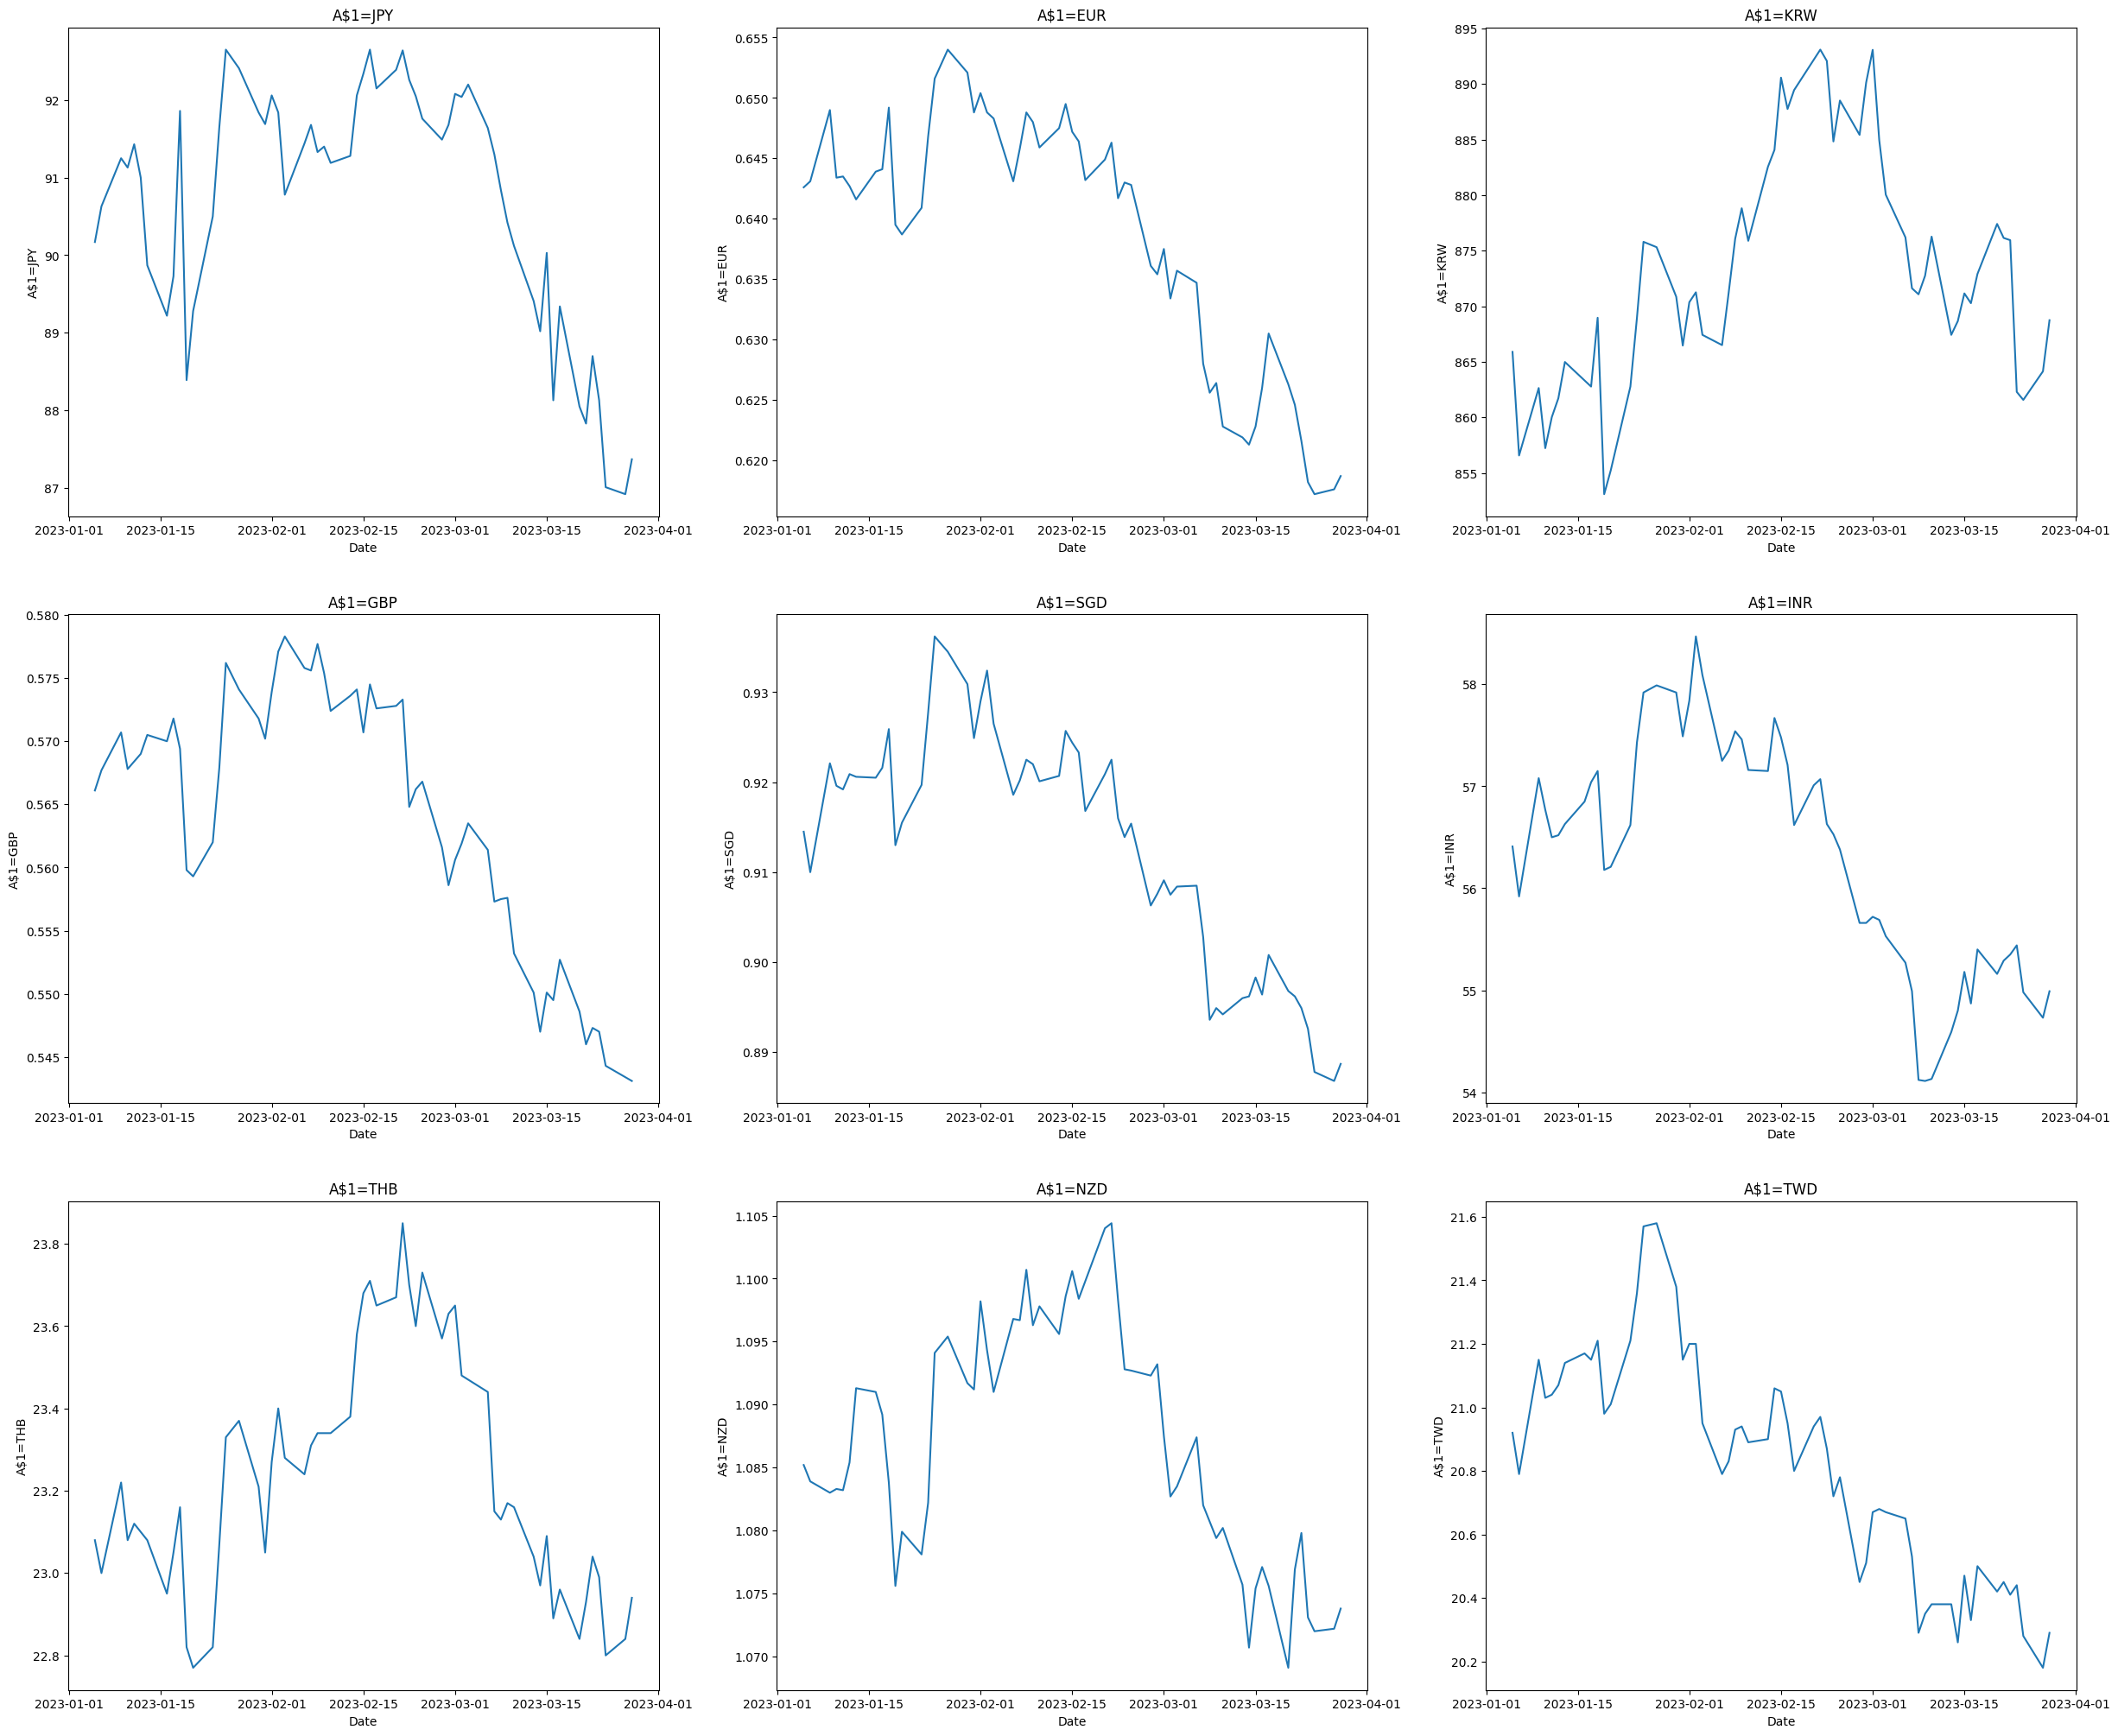

In [8]:
import matplotlib.pyplot as plt

# Drop columns with all NaN values so only plotting columns with values
data.dropna(axis=1, how="all", inplace=True)

# Define the columns to plot
cols_to_plot = data.columns[4:]

# Define the number of rows and columns for the subplots
nrows = 3
ncols = 3

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 25))

# Flatten the axes into a 1D array
axes = axes.flatten()

# Plot each column in a separate subplot
for i, col in enumerate(cols_to_plot):
    data.plot(x="Date", y=col, ax=axes[i], legend=False)
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel(col)
    axes[i].set_title(col)

# Adjust the layout and spacing of the subplots
plt.tight_layout()

# Display the plots
plt.show()